# План работы
- 1 Предварительная обработка
- 2 Предварительный анализ. Изучение данных.
- 3 Подготовка данных
- 4 Исследование задачи
- 5 Борьба с дисбалансом

> - Взвешивание классов
> - upsampling 
> - downsampling

- 6 Тестирование модели

- Вывод

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import itertools

from timeit import default_timer as timer
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, 
                             confusion_matrix, 
                             f1_score, 
                             roc_curve, 
                             precision_score, 
                             recall_score, 
                             auc)
from sklearn.model_selection import (train_test_split,  
                                     cross_val_score)



# 1. Предварительная обработка

In [2]:
# возвращает топ с процентами
def get_top_percent(data):
    total = data.value_counts()
    percent = (data.value_counts() / data.value_counts().sum()*100)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).head(5)

In [3]:
data = pd.read_csv('Churn.csv')
display(data.head(3))
data.info()
data.describe()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


**Имеем следующие данные:**

---
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата
- Целевой признак
- Exited — факт ухода клиента

In [4]:
# Смотрим пропуски
data.isnull().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [5]:
# Проверка дубликатов
data.duplicated().sum()

0

**Удаляем столбцы, которые далее не пригодятся для обучения модели прогнозирования.**

In [6]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)

In [7]:
display(data.shape)

(10000, 11)

### Обработка пропусков

Столбец 'Tenure' имеет пропуски. заменим их равновероятно значениями из этого столбца - числами от 0 до 10, чтобы небыло отклонений, как если бы мы заполнили пропуски какимто одним числом все пропуски.

In [8]:
np.random.seed(42) 
data['Tenure'] = data['Tenure'].apply(lambda x: np.random.randint(max(data['Tenure'])+1) if (np.isnan(x)) else x)

In [9]:
data['Tenure'].value_counts()

2.0     1044
1.0     1023
8.0     1014
5.0     1004
7.0     1004
3.0     1003
4.0      976
9.0      975
6.0      965
10.0     509
0.0      483
Name: Tenure, dtype: int64

### Замена типов данных

В колонке 'Tenure' следует заменить тип данных на int64 для увеличения скорости обработки.

In [10]:
data['Tenure'].astype('int').dtypes

dtype('int32')

# 2. Предварительный анализ. Изучение данных.

Смотрим процент оттока клиентов.

In [11]:
# 1 - ушедшие клиенты
get_top_percent(data['Exited'])

,Total,Percent
0,7963,79.63
1,2037,20.37


In [12]:
# Посмотрим корреляцию
data.corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,-0.003965,0.004784,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,-0.003965,1.000000,-0.006543,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,0.004784,-0.006543,1.000000,-0.003937,0.009737,0.026341,-0.028375,0.011661,-0.012858
Balance,0.006268,0.028308,-0.003937,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.012238,-0.030680,0.009737,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,-0.005458,-0.011721,0.026341,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.025651,0.085472,-0.028375,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.001384,-0.007201,0.011661,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
Exited,-0.027094,0.285323,-0.012858,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


### Исследуем категориальные признаки

In [13]:
categories = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts', 'Tenure']
numbers = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

In [14]:
# Смотрим количество признаков
data[categories].nunique()

Geography          3
Gender             2
HasCrCard          2
IsActiveMember     2
NumOfProducts      4
Tenure            11
dtype: int64

In [15]:
# Исследуем Категориальные признаки по отдельности с целевым признаком
for categori in categories:
    display(data.pivot_table(index = categori, values=numbers + ['Exited'], aggfunc=['mean']))

mean                                                     
                 Age        Balance CreditScore EstimatedSalary    Exited
Geography                                                                
France     38.511767   62092.636516  649.668329    99899.180814  0.161548
Germany    39.771622  119730.116134  651.453567   101113.435102  0.324432
Spain      38.890997   61818.147763  651.333872    99440.572281  0.166734

mean                                                    
              Age       Balance CreditScore EstimatedSalary    Exited
Gender                                                               
Female  39.238389  75659.369139  650.831389   100601.541382  0.250715
Male    38.658237  77173.974506  650.276892    99664.576931  0.164559

mean                                                    
                 Age       Balance CreditScore EstimatedSalary    Exited
HasCrCard                                                               
0          39.112054  77920.787552  651.345331   100974.397711  0.208149
1          38.842381  75886.913330  650.187952    99721.161949  0.201843

mean                                                    
                      Age       Balance CreditScore EstimatedSalary    Exited
IsActiveMember                                                               
0               37.997938  77134.376863  647.973603   100767.203854  0.268509
1               39.791497  75875.422145  652.934188    99452.965894  0.142691

mean                                                    
                     Age       Balance CreditScore EstimatedSalary    Exited
NumOfProducts                                                               
1              39.673092  98551.870614  649.120968    99487.256851  0.277144
2              37.753595  51879.145813  652.188671   100452.012821  0.075817
3              43.195489  75458.328195  648.105263   104318.130564  0.827068
4              45.683333  93733.135000  653.583333   104763.723333  1.000000

mean                                                    
              Age       Balance CreditScore EstimatedSalary    Exited
Tenure                                                               
0.0     39.074534  78646.264327  651.826087    98865.876729  0.227743
1.0     39.482893  77180.663754  648.390029   101541.358983  0.222874
2.0     39.185824  75800.181351  652.639847    98318.664837  0.193487
3.0     38.971087  77900.108096  650.358923    96979.045972  0.208375
4.0     38.110656  75345.178945  650.580943   100297.680574  0.209016
5.0     39.140438  75181.265090  649.797809   100656.134542  0.201195
6.0     38.690155  75195.333337  646.879793   100136.109762  0.200000
7.0     38.287849  76782.980030  650.316733   101271.773914  0.176295
8.0     38.532544  78066.736075  648.483235   101418.639901  0.188363
9.0     39.736410  76741.564544  656.400000    99194.372287  0.224615
10.0    39.039293  74641.534794  651.108055   103238.084126  0.200393

Найден интересный факт: Клиенты использующие более двух продуктов банка уходят в большинстве случаев: 3 продукта - в 82% случаев, 4 продукта в 100% случаев. Возможно качество продукта не удовлетворяет клиентов, или спектр продуктов не покрывает всех потребостей.

Рассмотрим этот факт.

<AxesSubplot:xlabel='NumOfProducts', ylabel='count'>

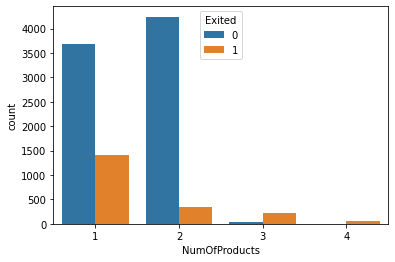

In [16]:
sns.countplot(x='NumOfProducts', hue='Exited', data=data)

In [17]:
print('Количество вышедших клиентов взависимости от количества продуктов и их общий баланс' )
data.groupby('NumOfProducts')['Exited', 'Balance'].sum()

Количество вышедших клиентов взависимости от количества продуктов и их общий баланс


c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Exited,Balance
NumOfProducts,,
1,1409,5.010377e+08
2,348,2.381253e+08
3,220,2.007192e+07
4,60,5.623988e+06


**Просмотрим остальные категории на предмет очевидных зависимостей на отток клиентов. Изучаем баланс**

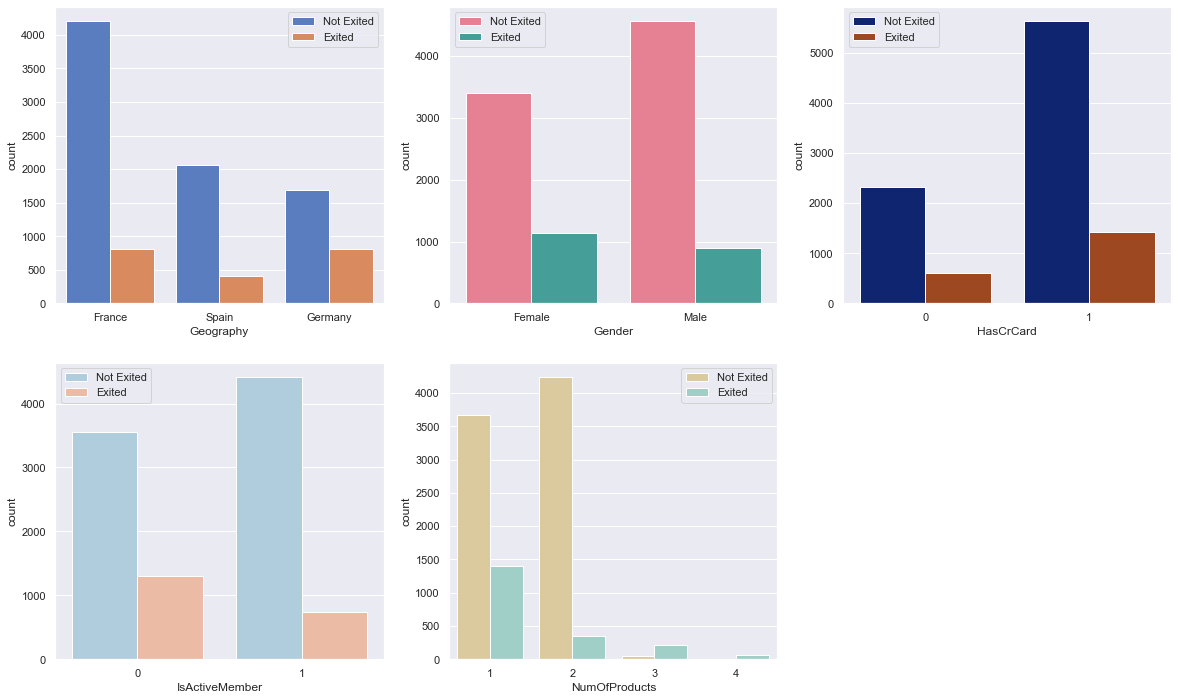

In [18]:
sns.set(color_codes=True)
plt.figure(figsize=(20,12))

color=["muted","husl","dark","RdBu_r","BrBG"]

for i in range(5):
    plt.subplot(2,3,i+1)
    sns.countplot(x=categories[i], hue='Exited', data=data, palette=color[i])
    plt.xticks(rotation=0)
    plt.legend(["Not Exited", "Exited"])
plt.show()

<AxesSubplot:xlabel='Geography', ylabel='Balance'>

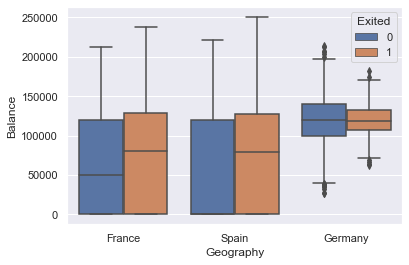

In [19]:
# Баланс по странам
sns.boxplot(x=data['Geography'], y=data['Balance'], hue=data['Exited'])

Интересное распределение оставшихся клиентов в Испании. Медиана = 0. Рассмотрим подробнее.

In [20]:
data.loc[(data['Geography'] == 'Spain') & (data['Exited'] == 0)].describe()


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.0
mean,652.104167,37.839147,5.014050,59678.070470,1.544574,0.699128,0.567345,98602.369864,0.0
std,93.292182,10.190398,2.879936,63489.039682,0.511572,0.458748,0.495564,57142.591384,0.0
min,413.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,479.540000,0.0
25%,587.000000,31.000000,3.000000,0.000000,1.000000,0.000000,0.000000,49317.772500,0.0
50%,652.000000,36.000000,5.000000,0.000000,2.000000,1.000000,1.000000,98768.455000,0.0
75%,715.000000,42.000000,8.000000,119805.890000,2.000000,1.000000,1.000000,146336.357500,0.0
max,850.000000,88.000000,10.000000,221532.800000,3.000000,1.000000,1.000000,199992.480000,0.0


In [21]:
# Посмотрим количество клиентов с нулевым балансом
get_top_percent(data[(data['Balance'] == 0) & (data['Geography'] == 'Spain')]['Exited'])

,Total,Percent
0,1036,86.405338
1,163,13.594662


Ничего особенного. Просто очень много клиентов с нулевым балансом. Возможно такова политика банка.

### Исследуем численные признаки

In [22]:
# Смотрим свойства признаков
data[numbers].nunique()

CreditScore         460
Age                  70
Balance            6382
EstimatedSalary    9999
dtype: int64

In [23]:
def print_box(dataset, column_name, axn):
    data_select = dataset.loc[:,[column_name]]
    data_select.boxplot(widths = 0.5 , ax=axn)

def box_plot(dataset, columns):
    fig, axis = plt.subplots(1, len(columns), figsize=(12, 6))
    ax = axis.ravel()
    for i in range(len(columns)):
        print_box(dataset, columns[i], ax[i])
    fig.tight_layout()

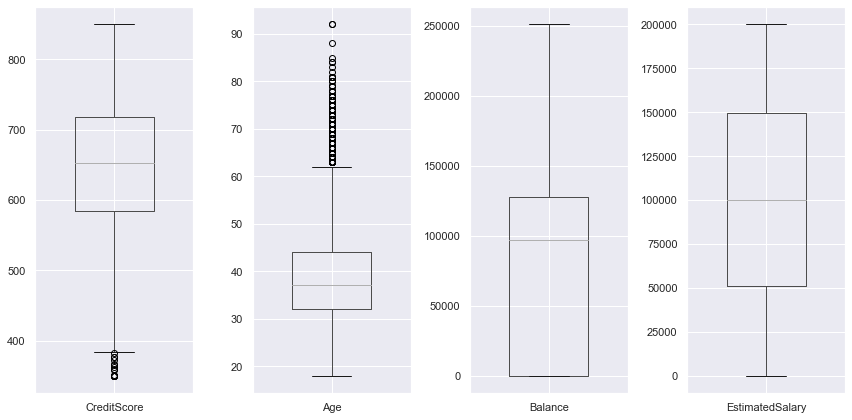

In [24]:
# Смотрим выбросы
box_plot(data, numbers)

Вызывают интерес Колонки "Age" и "Balance". Изучим.

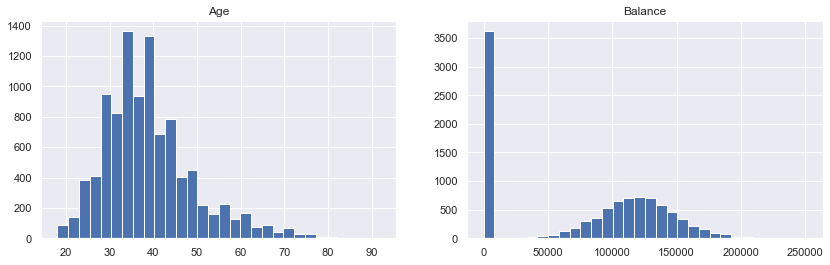

In [25]:
# Гистограммы 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
ax1.hist(data['Age'], bins=30)
ax1.set_title('Age')
ax2.hist(data['Balance'], bins=30)
ax2.set_title('Balance')

plt.show()

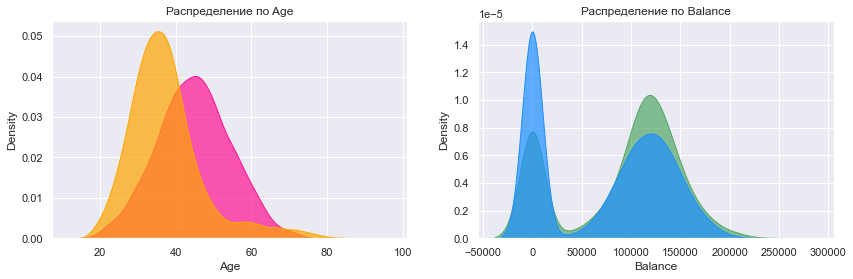

In [26]:
# распределения
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sns.kdeplot(data.loc[data['Exited'] == 1, 'Age'], shade=True, color="deeppink", label="Ушли", alpha=.7, ax = ax1)
sns.kdeplot(data.loc[data['Exited'] == 0, 'Age'], shade=True, color="orange", label="Остались", alpha=.7, ax = ax1)
sns.kdeplot(data.loc[data['Exited'] == 1, 'Balance'], shade=True, color="g", label="Ушли", alpha=.7, ax = ax2)
sns.kdeplot(data.loc[data['Exited'] == 0, 'Balance'], shade=True, color="dodgerblue", label="Остались", alpha=.7, ax = ax2)
ax1.set_title('Распределение по Age')
ax2.set_title('Распределение по Balance')
plt.show()

In [27]:
print('Отток с нулевым балансом')
get_top_percent(data[data['Balance'] == 0]['Exited'])


Отток с нулевым балансом


,Total,Percent
0,3117,86.176389
1,500,13.823611


## Вывод

Уходят наиболее состоятельные и стабильные клиенты в среднем 45 лет с балансом 120000. Остаются клиенты в среднем 35 лет. Среди клиентов имеющих нулевой баланс оставшихся 86 % против 80% в общей потере.

Данные очень разбалансированы

# 3. Подготовка данных

In [28]:
# Кодирование категориальных признаков, обработка dummy trap 
data = pd.get_dummies(data, drop_first=True)

In [29]:
# Масштабирование признаков. Стандартизация данных
scaler = StandardScaler()
scaler.fit(data[numbers])
data[numbers] = scaler.transform(data[numbers])

In [30]:
data.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,-0.326221,0.293517,2.0,-1.225848,1,1,1,0.021886,1,0,0,0
1,-0.440036,0.198164,1.0,0.117350,1,0,1,0.216534,0,0,1,0
2,-1.536794,0.293517,8.0,1.333053,3,1,0,0.240687,1,0,0,0
3,0.501521,0.007457,1.0,-1.225848,2,0,0,-0.108918,0,0,0,0
4,2.063884,0.388871,2.0,0.785728,1,1,1,-0.365276,0,0,1,0


In [31]:
# Разделим признаки на тренировочный и целевой
features = data.drop(['Exited'], axis=1)
target = data['Exited']

In [32]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

In [33]:
print('    Размеры выборок')
print('features_train size:', features_train.shape[0])
print('features_valid size:', features_valid.shape[0])
print('features_test size:', features_test.shape[0])

    Размеры выборок
features_train size: 6000
features_valid size: 2000
features_test size: 2000


# 4. Исследование задачи

Прогнозирование ухода клиента из банка является задачей классификации. Оценим предварительно точность различных моделей на несбалансированных данных. Выберем лучший классификатор.

### Выбор модели Вариант 1

Сравниваем метрики классификаторов с гиперпараметрами "по умолчанию"

In [34]:
def score_pack(predict, target):
    accuracy = accuracy_score(predict, target)
    print('Accuracy:{:.3f}'.format(accuracy))
    print('Precission: {:.3f}'.format(precision_score(target, predict)))
    print('Recall: {:.3f}'.format(recall_score(target, predict)))
    print('F1_Score: {:.3f}'.format(f1_score(target, predict)))
    return confusion_matrix(target, predict)
    

In [35]:
classifiers = {
    "LogisiticRegression": LogisticRegression(random_state=12345, solver='liblinear'),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=12345),
    "RandomForestClassifier": RandomForestClassifier(random_state=12345)
}

for key, classifier in classifiers.items():
    classifier.fit(features_train, target_train)
    predicted_valid = classifier.predict(features_valid)
    print(key)
    score_pack(predicted_valid, target_valid)
    print('==='*10)

LogisiticRegression
Accuracy:0.803
Precission: 0.572
Recall: 0.237
F1_Score: 0.335
DecisionTreeClassifier
Accuracy:0.788
Precission: 0.493
Recall: 0.486
F1_Score: 0.489
RandomForestClassifier
Accuracy:0.862
Precission: 0.783
Recall: 0.467
F1_Score: 0.585


Наилучший результат показывает модель классификатора случайный лес: Accuracy:0.851, F1_Score: 0.545. Далее будем использовать RandomForestClassifier.

### Выбор модели. Вариант 2

In [36]:
kfold = 5 #количество подвыборок для валидации
itog_val = {} #список для записи результатов кросс валидации разных алгоритмов

In [37]:
model_forest = RandomForestClassifier(random_state=12345, n_estimators = 30)
model_tree = DecisionTreeClassifier(random_state=12345, max_depth=15)
model_lr = LogisticRegression(random_state=12345, solver='liblinear') 

In [38]:
#print(cross_val_score(lasso, X, y, cv=3))
# cross_val_score сама разделяет обучающую и валид. выборку
scores = cross_val_score(model_forest, features, target, cv = kfold) 
itog_val['RandomForestClassifier'] = scores.mean()
scores = cross_val_score(model_tree, features, target, cv = kfold)
itog_val['DecisionTreeClassifier'] = scores.mean()
scores = cross_val_score(model_lr, features, target, cv = kfold)
itog_val['LogisticRegression'] = scores.mean()


<AxesSubplot:title={'center':'средний показатель перекрестной проверки каждой модели'}>

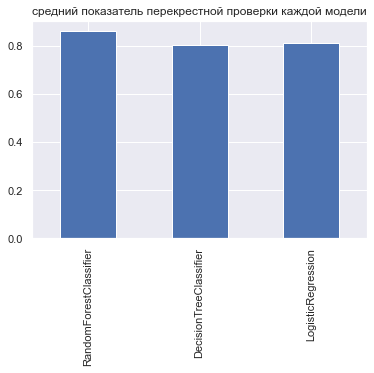

In [39]:
# средний показатель тестов перекрестной проверки каждой модели:
(pd.DataFrame.from_dict(data = itog_val, orient='index')
             .plot(grid = True, 
                   kind='bar', 
                   legend=False, 
                   title = 'средний показатель перекрестной проверки каждой модели'))

Выберем по площади под кривой ROC

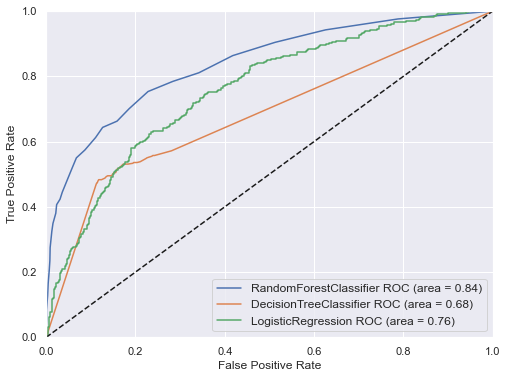

In [40]:
'''  
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()'''

plt.figure(figsize=(8,6))

#RandomForestClassifier
probabilities = model_forest.fit(features_train, target_train).predict_proba(features_valid)
fpr, tpr, thresholds = roc_curve(target_valid, probabilities[:, 1])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='{} ROC (area = {:.2f})'.format('RandomForestClassifier',roc_auc))
#DecisionTreeClassifier
probabilities = model_tree.fit(features_train, target_train).predict_proba(features_valid)
fpr, tpr, thresholds = roc_curve(target_valid, probabilities[:, 1])
roc_auc  = auc(fpr, tpr) # просто, чтобы не одинаково :)
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('DecisionTreeClassifier',roc_auc))
#LogisticRegression
probabilities = model_lr.fit(features_train, target_train).predict_proba(features_valid)
fpr, tpr, thresholds = roc_curve(target_valid, probabilities[:, 1])
roc_auc  = auc(fpr, tpr) 
plt.plot(fpr, tpr, label='LogisticRegression ROC (area = {:.2f})'.format(roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.grid(True)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0, fontsize='12')
plt.show()

Побеждает также RandomForestClassifier

## Вывод
RandomForestClassifier показывает наилучшие пробные результаты. Далее будем использовать эту модель.

# 5. Борьба с дисбалансом

### Взвешивание классов

Изучаем, влияет ли взвешивание классов на эффективность модели. Выбираем class_weight

In [41]:
# Глобальные переменные
best_F1_score = 0.0
best_train_model: object()


In [42]:
# возвращает обученную модель и время обучения. Лучшую модель и метрику записывает в переменные best_train_model, best_F1_score
def model_fit(model, features, target):
    global best_train_model
    global best_F1_score
    t = timer()
    model.fit(features, target)
    elapsed = timer() - t
    predictions = model.predict(features_valid)
    model_score = f1_score(target_valid, predictions)
    if model_score > best_F1_score:
        best_F1_score = model_score
        best_train_model = model
    return model_score, elapsed

In [43]:
# Гиперпараметры 
greater_depth = 20  #  max_depth
step_depth = 3 # шаг depth
n_estimator = 101  # n_estimators
step_estimators = 30 # шаг n_estimators
# подбирает гиперпараметры. выводит информацию о лучшей модели.
def search_hyperparameters(balanced, features, target):
    compare_f1 = best_F1_score
    for depth,estimator in itertools.product(range(2,greater_depth,step_depth), range(1,n_estimator,step_estimators)):
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=estimator, class_weight= balanced)
        model_score, elapsed = model_fit(model, features, target)
        print('f1_Score: {:.3f}, fit_time: {:.3f}, depth: {}, n_estimators: {}'.format(model_score, elapsed, depth, estimator))
    if best_F1_score > compare_f1:
        print('==='*20)
        print('найдена лучшая модель: f1_Score: {:.3f}\n'.format(best_F1_score), best_train_model)
    else:
        print('==='*20)
        print('Лучшего результата нет')        

**Подбираем гиперпараметрами лучшую модель с несбалансированными классами (default class_weight= None)**

In [44]:
search_hyperparameters(None, features_train, target_train)

f1_Score: 0.248, fit_time: 0.009, depth: 2, n_estimators: 1
f1_Score: 0.134, fit_time: 0.074, depth: 2, n_estimators: 31
f1_Score: 0.162, fit_time: 0.135, depth: 2, n_estimators: 61
f1_Score: 0.113, fit_time: 0.255, depth: 2, n_estimators: 91
f1_Score: 0.437, fit_time: 0.006, depth: 5, n_estimators: 1
f1_Score: 0.484, fit_time: 0.102, depth: 5, n_estimators: 31
f1_Score: 0.478, fit_time: 0.202, depth: 5, n_estimators: 61
f1_Score: 0.469, fit_time: 0.309, depth: 5, n_estimators: 91
f1_Score: 0.522, fit_time: 0.008, depth: 8, n_estimators: 1
f1_Score: 0.559, fit_time: 0.139, depth: 8, n_estimators: 31
f1_Score: 0.564, fit_time: 0.270, depth: 8, n_estimators: 61
f1_Score: 0.564, fit_time: 0.431, depth: 8, n_estimators: 91
f1_Score: 0.529, fit_time: 0.013, depth: 11, n_estimators: 1
f1_Score: 0.564, fit_time: 0.235, depth: 11, n_estimators: 31
f1_Score: 0.572, fit_time: 0.303, depth: 11, n_estimators: 61
f1_Score: 0.576, fit_time: 0.439, depth: 11, n_estimators: 91
f1_Score: 0.508, fit_tim

**Подбираем гиперпараметрами лучшую модель с балансированными классами (class_weight='balanced')**

In [45]:
search_hyperparameters('balanced', features_train, target_train)

f1_Score: 0.402, fit_time: 0.008, depth: 2, n_estimators: 1
f1_Score: 0.564, fit_time: 0.109, depth: 2, n_estimators: 31
f1_Score: 0.568, fit_time: 0.155, depth: 2, n_estimators: 61
f1_Score: 0.576, fit_time: 0.240, depth: 2, n_estimators: 91
f1_Score: 0.523, fit_time: 0.009, depth: 5, n_estimators: 1
f1_Score: 0.610, fit_time: 0.115, depth: 5, n_estimators: 31
f1_Score: 0.613, fit_time: 0.211, depth: 5, n_estimators: 61
f1_Score: 0.606, fit_time: 0.309, depth: 5, n_estimators: 91
f1_Score: 0.555, fit_time: 0.008, depth: 8, n_estimators: 1
f1_Score: 0.626, fit_time: 0.143, depth: 8, n_estimators: 31
f1_Score: 0.624, fit_time: 0.292, depth: 8, n_estimators: 61
f1_Score: 0.628, fit_time: 0.586, depth: 8, n_estimators: 91
f1_Score: 0.503, fit_time: 0.008, depth: 11, n_estimators: 1
f1_Score: 0.597, fit_time: 0.189, depth: 11, n_estimators: 31
f1_Score: 0.619, fit_time: 0.381, depth: 11, n_estimators: 61
f1_Score: 0.622, fit_time: 0.468, depth: 11, n_estimators: 91
f1_Score: 0.473, fit_tim

Лучшая модель с одинаковыми гиперпараметрими:

In [46]:
print('Лучшая модель с одинаковыми гиперпараметрими: f1_Score: {:.3f}\n'.format(best_F1_score), best_train_model)

Лучшая модель с одинаковыми гиперпараметрими: f1_Score: 0.628
 RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=91,
                       random_state=12345)


### Итог
Использование взвешивания классов улучшает модель.

### Увеличение выборки

Еще раз взглянем на баланс классов целевого признака

c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Exited', ylabel='count'>

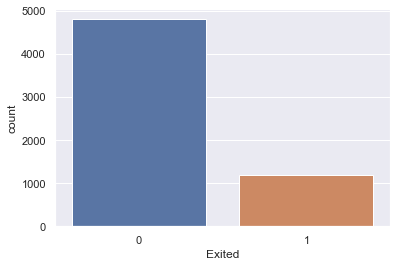

In [47]:
sns.countplot(target_train )

In [48]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

features_upsampled: 9588
features_train size: 6000
features_valid size: 2000


c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Exited', ylabel='count'>

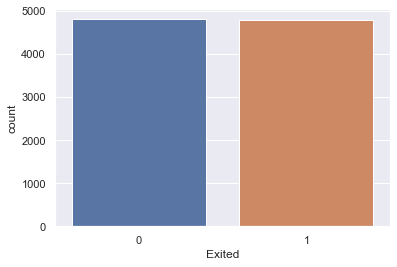

In [49]:
print('features_upsampled:', features_upsampled.shape[0])
print('features_train size:', features_train.shape[0])
print('features_valid size:', features_valid.shape[0])
sns.countplot(target_upsampled)

In [50]:
search_hyperparameters('balanced', features_upsampled, target_upsampled)

f1_Score: 0.402, fit_time: 0.009, depth: 2, n_estimators: 1
f1_Score: 0.551, fit_time: 0.108, depth: 2, n_estimators: 31
f1_Score: 0.557, fit_time: 0.180, depth: 2, n_estimators: 61
f1_Score: 0.559, fit_time: 0.262, depth: 2, n_estimators: 91
f1_Score: 0.553, fit_time: 0.009, depth: 5, n_estimators: 1
f1_Score: 0.601, fit_time: 0.137, depth: 5, n_estimators: 31
f1_Score: 0.605, fit_time: 0.453, depth: 5, n_estimators: 61
f1_Score: 0.600, fit_time: 0.472, depth: 5, n_estimators: 91
f1_Score: 0.547, fit_time: 0.016, depth: 8, n_estimators: 1
f1_Score: 0.619, fit_time: 0.234, depth: 8, n_estimators: 31
f1_Score: 0.621, fit_time: 0.407, depth: 8, n_estimators: 61
f1_Score: 0.623, fit_time: 0.570, depth: 8, n_estimators: 91
f1_Score: 0.540, fit_time: 0.011, depth: 11, n_estimators: 1
f1_Score: 0.624, fit_time: 0.220, depth: 11, n_estimators: 31
f1_Score: 0.619, fit_time: 0.439, depth: 11, n_estimators: 61
f1_Score: 0.619, fit_time: 0.644, depth: 11, n_estimators: 91
f1_Score: 0.505, fit_tim

### Уменьшение выборки

In [51]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

target_downsampled: 2397
features_train size: 6000
features_valid size: 2000


c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


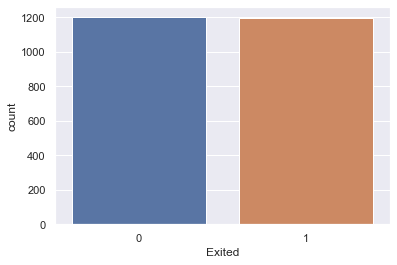

In [52]:
sns.countplot(target_downsampled)
print('target_downsampled:', target_downsampled.shape[0])
print('features_train size:', features_train.shape[0])
print('features_valid size:', features_valid.shape[0])

In [53]:
search_hyperparameters('balanced', features_downsampled, target_downsampled)

f1_Score: 0.402, fit_time: 0.005, depth: 2, n_estimators: 1
f1_Score: 0.551, fit_time: 0.058, depth: 2, n_estimators: 31
f1_Score: 0.558, fit_time: 0.104, depth: 2, n_estimators: 61
f1_Score: 0.564, fit_time: 0.154, depth: 2, n_estimators: 91
f1_Score: 0.516, fit_time: 0.005, depth: 5, n_estimators: 1
f1_Score: 0.585, fit_time: 0.071, depth: 5, n_estimators: 31
f1_Score: 0.581, fit_time: 0.111, depth: 5, n_estimators: 61
f1_Score: 0.584, fit_time: 0.175, depth: 5, n_estimators: 91
f1_Score: 0.555, fit_time: 0.007, depth: 8, n_estimators: 1
f1_Score: 0.606, fit_time: 0.075, depth: 8, n_estimators: 31
f1_Score: 0.604, fit_time: 0.155, depth: 8, n_estimators: 61
f1_Score: 0.606, fit_time: 0.217, depth: 8, n_estimators: 91
f1_Score: 0.502, fit_time: 0.006, depth: 11, n_estimators: 1
f1_Score: 0.576, fit_time: 0.091, depth: 11, n_estimators: 31
f1_Score: 0.573, fit_time: 0.179, depth: 11, n_estimators: 61
f1_Score: 0.577, fit_time: 0.244, depth: 11, n_estimators: 91
f1_Score: 0.466, fit_tim

### Итог  


In [54]:
print('Лучшая модель: f1_Score: {:.3f}\n'.format(best_F1_score), best_train_model)

Лучшая модель: f1_Score: 0.628
 RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=91,
                       random_state=12345)


## Вывод
Использование взвешивания классов улучшает модель. Изменение выборки улучшение модели не показало.

# 6. Тестирование модели

**Проводим предсказание и измерение на тестовом датасете**

In [55]:
predicted_test = best_train_model.predict(features_test)
score_pack(predicted_test, target_test)

Accuracy:0.817
Precission: 0.554
Recall: 0.676
F1_Score: 0.609


array([[1347,  230],
       [ 137,  286]], dtype=int64)

**Объединим обучающую и валидационную выборки. Обучим модель на объединенном датасете**

In [56]:
final_features = pd.concat([features_train]+[features_valid])
final_target = pd.concat([target_train]+[target_valid])


best_train_model.fit(final_features, final_target)
predicted_test = best_train_model.predict(features_test)
score_pack(predicted_test, target_test)

Accuracy:0.826
Precission: 0.573
Recall: 0.690
F1_Score: 0.626


array([[1359,  218],
       [ 131,  292]], dtype=int64)

**Исследуем метрику AUC-ROC. Строим график.**

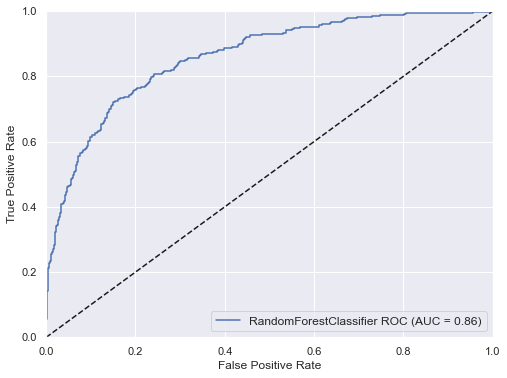

In [57]:

plt.figure(figsize=(8,6))
probabilities = best_train_model.predict_proba(features_test)
fpr, tpr, thresholds = roc_curve(target_test, probabilities[:, 1])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='{} ROC (AUC = {:.2f})'.format('RandomForestClassifier',roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.grid(True)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0, fontsize='12')
plt.show()

## Вывод 
Удалось достичь F1-меры не менее 0.59. Использование взвешивания классов позволило улучшить модель. Изменение выборки 
upsampling и downsampling положительных результатов не показало. Обучение на объединенном датасете позволо улучшить модель. 

Площадь под ROC-кривой показывает как сильно модель отличается от случайной. AUC-ROC нашей модели равна 0.86. AUC-ROC случайной модели равна 0.5.